# Desafio: estágio Data Engineering


### Imports

In [1]:
# data analysis and data wrangling
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import configparser
import subprocess
import warnings
import time
import os
import gc # clear RAM

### Prepare Principal Directory

In [2]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname (os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}'

In [3]:
prepare_directory_work(end_directory='notebooks')

'/home/campos/projetos/challenges/challenge-indicium/notebooks'

### Load data

In [4]:
%%time

# usei utf8 para corrigir a leitura dos acentos
# tsv é separado por tab
deals = pd.read_csv('data/raw/deals.tsv', 
                    sep='\t',
                    encoding='utf-8')
sectors = pd.read_csv('data/raw/sectors.tsv', 
                      sep='\t', 
                      encoding='utf-8')
companies = pd.read_csv('data/raw/companies.tsv',
                        sep='\t',
                        encoding='utf-8')
contacts = pd.read_csv('data/raw/contacts.tsv',
                       sep='\t',
                       encoding='utf-8')

CPU times: user 55 ms, sys: 0 ns, total: 55 ms
Wall time: 55.5 ms


### Prepare Environment

In [5]:
# from <package>.<module> import <class>
from src.environment.prepare_env import *


main()

Requirements this project:

matplotlib==3.1.1
numpy==1.16.4
seaborn==0.9.0
pandas==0.24.2
ipython==7.6.1
scikit_learn==0.21.2
atlas==0.27.0

--------------------------------------------------
Configuration Environment:

OS:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 19.04
Release:	19.04
Codename:	disco

Python Version:
Python 3.7.3

Pip Version:
pip 19.1.1 from /home/campos/projetos/challenges/challenge-indicium/src/environment/venv/lib/python3.7/site-packages/pip (python 3.7)

Jupyter Version:
4.4.0

--------------------------------------------------

Disk Usage:

data:
48K	data/

virtual env:

all:
380M	.

--------------------------------------------------
Structure This Project:

.
├── data
│   ├── cleansing
│   │   └── output.csv
│   └── raw
│       ├── companies.tsv
│       ├── contacts.tsv
│       ├── deals.tsv
│       └── sectors.tsv
├── notebooks
│   └── challege-data-enginner-intern.ipynb
├── README.md
├── reports
│   ├── valor_total_vendido_por_contato.png
│   ├── valor

### Format cell

In [6]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# parametros de config
rc={'savefig.dpi': 75, 
    'figure.autolayout': False, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 18, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 16,
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']
# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Análise e limpeza dos dados

In [7]:
deals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
dealsId             100 non-null int64
dealsDateCreated    100 non-null object
dealsPrice          100 non-null int64
contactsId          100 non-null int64
companiesId         100 non-null int64
dtypes: int64(4), object(1)
memory usage: 4.0+ KB


In [8]:
sectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
sectorKey    6 non-null int64
sector       6 non-null object
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


In [9]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
companiesId             74 non-null int64
companiesName           74 non-null object
companiesDateCreated    74 non-null object
createdBy               74 non-null object
companiesEmails         74 non-null object
companiesPhones         74 non-null object
employeesId             74 non-null int64
employeesName           74 non-null object
usersResponsible        74 non-null object
sectorKey               74 non-null int64
dtypes: int64(3), object(7)
memory usage: 5.9+ KB


In [10]:
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 contactsId              74 non-null int64
contactsName             74 non-null object
contactsDateCreated      74 non-null object
contactsCreatedBy        74 non-null object
contactsEmails           74 non-null object
contactsPhones           74 non-null object
contactsEmployers        74 non-null object
employersId              74 non-null int64
contactsHomeAdress       74 non-null object
contactsLatLong          74 non-null object
contactsRelatedToLead    74 non-null int64
contactsResponsible      74 non-null object
dtypes: int64(3), object(9)
memory usage: 7.0+ KB


### Há um espaço em branco no metadado da primeira coluna da tabela _contacts_

In [11]:
# renomeei cada coluna para garantir que não há espaços em branco
contacts.columns = ['contactsId',
                    'contactsName',
                    'contactsDateCreated',
                    'contactsCreatedBy',
                    'contactsEmails',
                    'contactsPhones',
                    'contactsEmployers',
                    'employersId', 
                    'contactsHomeAdress',
                    'contactsLatLong',
                    'contactsRelatedToLead',
                    'contactsResponsible']
print(contacts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
contactsId               74 non-null int64
contactsName             74 non-null object
contactsDateCreated      74 non-null object
contactsCreatedBy        74 non-null object
contactsEmails           74 non-null object
contactsPhones           74 non-null object
contactsEmployers        74 non-null object
employersId              74 non-null int64
contactsHomeAdress       74 non-null object
contactsLatLong          74 non-null object
contactsRelatedToLead    74 non-null int64
contactsResponsible      74 non-null object
dtypes: int64(3), object(9)
memory usage: 7.0+ KB
None


### Conversão de tipos (date)

In [12]:
deals['dealsDateCreated'] = pd.to_datetime(deals['dealsDateCreated'])
deals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
dealsId             100 non-null int64
dealsDateCreated    100 non-null datetime64[ns]
dealsPrice          100 non-null int64
contactsId          100 non-null int64
companiesId         100 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 4.0 KB


In [13]:
contacts['contactsDateCreated'] = pd.to_datetime(contacts['contactsDateCreated'])
contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
contactsId               74 non-null int64
contactsName             74 non-null object
contactsDateCreated      74 non-null datetime64[ns]
contactsCreatedBy        74 non-null object
contactsEmails           74 non-null object
contactsPhones           74 non-null object
contactsEmployers        74 non-null object
employersId              74 non-null int64
contactsHomeAdress       74 non-null object
contactsLatLong          74 non-null object
contactsRelatedToLead    74 non-null int64
contactsResponsible      74 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 7.0+ KB


In [14]:
companies['companiesDateCreated'] = pd.to_datetime(companies['companiesDateCreated'])
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
companiesId             74 non-null int64
companiesName           74 non-null object
companiesDateCreated    74 non-null datetime64[ns]
createdBy               74 non-null object
companiesEmails         74 non-null object
companiesPhones         74 non-null object
employeesId             74 non-null int64
employeesName           74 non-null object
usersResponsible        74 non-null object
sectorKey               74 non-null int64
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 5.9+ KB


### Valores inválidos

 Não é possível haver _dealsDateCreated, contactsDateCreated e companiesDateCreated_ no futuro. Então, me basendo na data que recebi o desafio '2018-10-09' para ser o fator seletivo

In [15]:
# drop de linhas inválidas em deals
deals_clean = deals[deals.dealsDateCreated < "2018-10-09"]
print(f'Número de linhas descartadas em deals: {len(deals) - len(deals_clean)}')

# drop de linhas inválidas em contacts
contacts_clean = contacts[contacts.contactsDateCreated < "2018-10-09"]
print(f'Número de linhas descartadas em contacts: {len(contacts) - len(contacts_clean)}')

# drop de linhas inválidas em companies
companies_clean = companies[companies.companiesDateCreated < "2018-10-09"]
print(f'Número de linhas descartadas em companies: {len(companies) - len(companies_clean)}')

Número de linhas descartadas em deals: 45
Número de linhas descartadas em contacts: 26
Número de linhas descartadas em companies: 26


---

# OUTPUT 01: Gráficos

O primeiro OUTPUT deve conseguir servir de base para 2 gráficos: número de vendas por
contato e valor total vendido por mês.

### Join entre as tabels _deals_ e _contacts_

In [16]:
# O join vai servir para mapear o nome dos contacts
# vai auxiliar na exibição do gráfico com os nomes dos contacts

colunas_necessarias_contacts = ['contactsId','contactsName']
deals_contacts = pd.merge(deals_clean,
                          contacts_clean[colunas_necessarias_contacts],
                          left_on='contactsId', right_on='contactsId')
display(deals_contacts)

,dealsId,dealsDateCreated,dealsPrice,contactsId,companiesId,contactsName
0,10,2018-09-08,8880,11,29,Craig Boyd
1,5,2017-11-20,5030,11,28,Craig Boyd
2,7,2017-09-02,600,11,11,Craig Boyd
3,42,2017-12-26,2560,11,11,Craig Boyd
4,18,2018-04-05,3930,30,30,Cooper Sandoval
5,24,2018-01-01,3480,15,19,Jonah Day
6,20,2017-10-09,2380,15,19,Jonah Day
7,16,2018-05-04,6330,15,19,Jonah Day
8,45,2018-02-17,8890,15,19,Jonah Day
9,33,2018-05-12,7130,15,19,Jonah Day


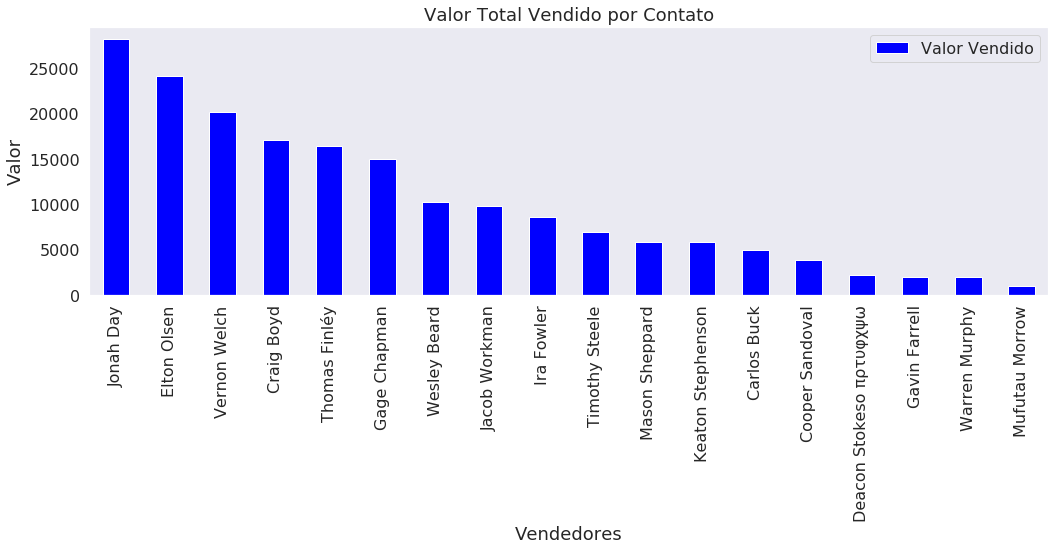

Output (valor_total_vendido_por_contato) salvo.


In [17]:
# organização dos dados
n_vendas_contato = deals_contacts.groupby('contactsName')['dealsPrice'].sum().sort_values(ascending=False)

# visualização do gráfico
n_vendas_contato = n_vendas_contato.plot(kind='bar',
                                         color='blue',
                                         label='Valor Vendido')
plt.xlabel('Vendedores')
plt.ylabel('Valor')
plt.title("Valor Total Vendido por Contato")
plt.legend(loc="upper right")
plt.legend()
plt.tight_layout() # salva imagem sem contar as palavras
plt.show()

# salvamento da imagem
fig = n_vendas_contato.get_figure()
fig.savefig(f'reports/valor_total_vendido_por_contato.png', dpi=500)
print(f"Output (valor_total_vendido_por_contato) salvo.")

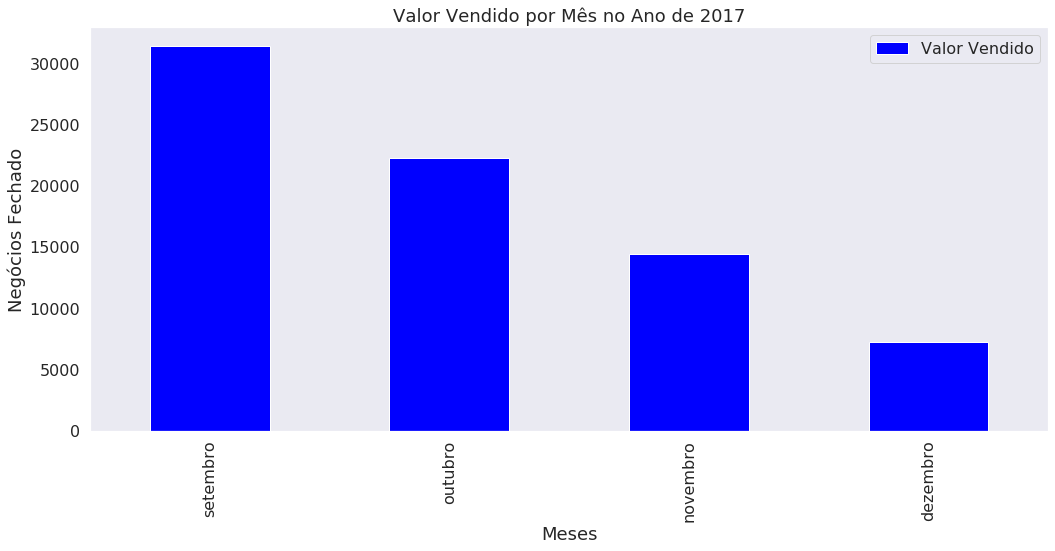

Output (Valor_total_vendido_por_mês-2017) salvo.


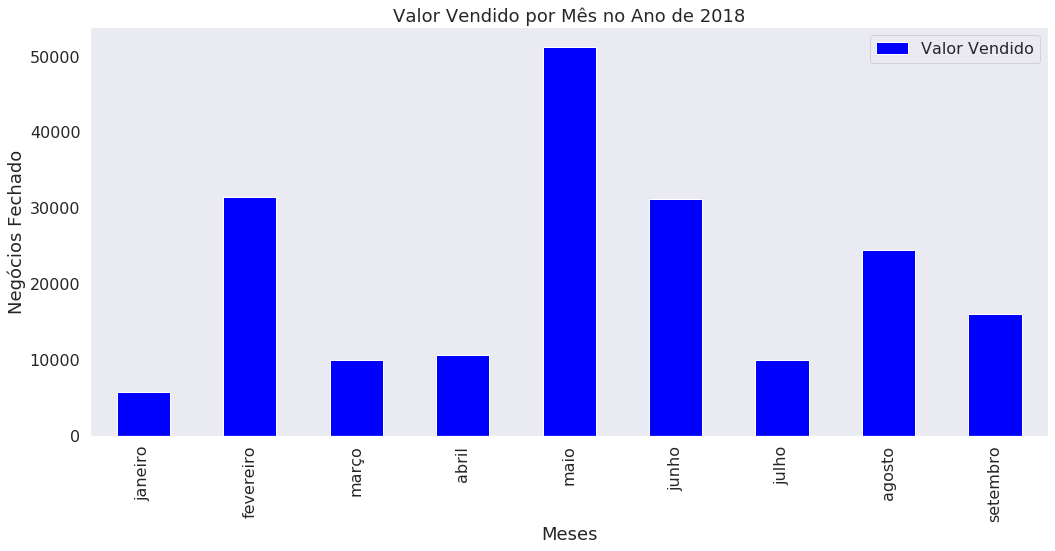

Output (Valor_total_vendido_por_mês-2018) salvo.


In [18]:
# organização dos dados: valor total vendido por mês a partir do ano
# percorre ano
for ano in range(2017,2019): 
    #print(ano)
    query_year = deals_clean[(deals_clean['dealsDateCreated'].dt.year==ano)]
    extrai_mes = pd.DatetimeIndex(query_year['dealsDateCreated']).month
    n_vendas_mes = query_year.groupby(extrai_mes)['dealsPrice'].sum()
    
    # para renomear as colunas do gráfico sera necessário renomear os índices do pandas series n_vendas_mes
    n_vendas_mes = n_vendas_mes.rename(index={1:"janeiro",
                                              2:"fevereiro",
                                              3:"março",
                                              4:"abril",
                                              5:"maio",
                                              6:"junho",
                                              7:"julho",
                                              8:"agosto",
                                              9:"setembro",
                                              10:"outubro",
                                              11:"novembro",
                                              12:"dezembro"})

    # visualização do gráfico
    n_vendas_mes_grafico = n_vendas_mes.plot(kind='bar',
                                             color='blue',
                                             label='Valor Vendido')
    plt.xlabel('Meses')
    plt.ylabel('Negócios Fechado')
    plt.title(f"Valor Vendido por Mês no Ano de {ano}")
    plt.legend(loc="upper right")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # salvamento da imagem
    fig = n_vendas_mes_grafico.get_figure()
    fig.savefig(f'reports/valor_total_vendido_por_mês-{ano}.png', dpi=500)
    print(f"Output (Valor_total_vendido_por_mês-{ano}) salvo.")

---

# OUTPUT 02: Lista das vendas por setores ordenado pelo mês
O segundo output deve ser uma lista dos setores de empresa, ordenado por quanto esse setor representa no total vendido pela empresa no mês. Por exemplo, considerando que a empresa vendeu 10k total, se o 8k foi vendido para empresas do setor 1 e 2k para empresas do setor 2 então a lista resultante seria:
- 1 Bens De Consumo 0.8
- 2 Serviços 0.2

Note que o nome do setor deve constar na lista.

In [19]:
# O join vai servir para mapear o nome dos sectors
colunas_necessarias_companies = ['companiesId', 'sectorKey' ]
companies_sectors = pd.merge(companies_clean[colunas_necessarias_companies], sectors,
                             left_on='sectorKey', right_on='sectorKey')

# join entre deals e companies_sectors
deals_companies_sectors = pd.merge(deals_clean, companies_sectors,
                                   left_on='companiesId', right_on='companiesId')

# Deixar a tabela já sorted por data
display(deals_companies_sectors.sort_values(by=['dealsDateCreated'], ascending=False))

,dealsId,dealsDateCreated,dealsPrice,contactsId,companiesId,sectorKey,sector
30,80,2018-09-16,740,55,55,4,Indústria
0,10,2018-09-08,8880,11,29,4,Indústria
13,11,2018-09-08,1450,13,13,2,Serviços
14,68,2018-09-05,4960,23,23,3,Tecnologia
11,44,2018-08-15,5930,63,63,2,Serviços
12,55,2018-08-11,8880,13,13,2,Serviços
22,83,2018-06-26,9590,3,3,6,Atacado
29,63,2018-06-20,9650,45,45,2,Serviços
15,86,2018-06-13,7010,35,35,2,Serviços
23,34,2018-05-13,6840,3,3,6,Atacado


#### OBS:
Faltou analisar a complexidade algoritma. Cada `for` faz a complexidade aumentar exponencialmente.

In [20]:
# neste dataframe vou armazenar o valor total vendido por mês, separado por setor
table_result = pd.DataFrame(columns=['Ano','Mês', 'Setor', 'Valor Total Vendido Mensal'])

# conversão das colunas Object para int
table_result.Ano = table_result.Ano.astype(int)
table_result.Mês = table_result.Mês.astype(int)
table_result.Setor = table_result.Setor.astype(int)
table_result['Valor Total Vendido Mensal'] = table_result['Valor Total Vendido Mensal'].astype(int)

# percorre ano
for ano in range(2017,2019): 
    #print(ano)
    query_year = deals_companies_sectors[(deals_companies_sectors['dealsDateCreated'].dt.year==ano)]

    # percorre mês
    for mes in range(1,13):
        #print(mes)
        query_year_month = query_year[(query_year['dealsDateCreated'].dt.month==mes)]        
        
        # percorre setor (é menos custoso comparar valores numéricos, então query_year_month['sectorKey'])
        for setor in query_year_month['sectorKey']:
            #print(setor)
            query_sector_month = query_year_month[(query_year_month['sectorKey']==setor)]
                            
            # group by dealsPrice
            grouping = query_sector_month\
                                        .groupby('sector')['dealsPrice']\
                                            .sum()\
                                                .sort_values(ascending=False)

            # variável p organizar a inserção no dataframe grouping_sector_month
            data = pd.DataFrame([[ano,
                                  mes,
                                  setor,
                                  grouping[0]]], 
                                columns=['Ano',
                                         'Mês',
                                         'Setor',
                                         'Valor Total Vendido Mensal'])
            table_result = table_result.append(data)
            
            table_result = table_result.drop_duplicates(keep='first')
            
table_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 0
Data columns (total 4 columns):
Ano                           28 non-null int64
Mês                           28 non-null int64
Setor                         28 non-null int64
Valor Total Vendido Mensal    28 non-null int64
dtypes: int64(4)
memory usage: 1.1 KB


### Mapeamento e ordenação

In [21]:
# mapeamento do nome do setor. Aqui a tabela é bem menor e não é necessário fazer comparações
dict_setor = {1:"Bens de Consumo",
              2:"Serviços",
              3:"Tecnologia",
              4:"Indústria",
              5:"Varejo",
              6:"Atacado"}
table_result['Setor'] = table_result['Setor'].map(dict_setor)

table_result = table_result.sort_values(by=['Ano',
                                            'Mês',
                                            'Valor Total Vendido Mensal',
                                            'Setor'],
                                        ascending=False)

In [22]:
display(table_result)

,Ano,Mês,Setor,Valor Total Vendido Mensal
0,2018,9,Indústria,9620
0,2018,9,Tecnologia,4960
0,2018,9,Serviços,1450
0,2018,8,Serviços,14810
0,2018,6,Serviços,16660
0,2018,6,Atacado,9590
0,2018,5,Indústria,13460
0,2018,5,Varejo,8680
0,2018,5,Atacado,6840
0,2018,4,Tecnologia,3930


### Salvamento do dataframe

In [23]:
def save_data_clenning(df: 'dataframe' = None,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "Data storage!"

In [24]:
save_data_clenning(df = table_result,
                   path = 'data/cleansing/output.csv')

'Data storage!'

---

#### Copyright
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
    <img alt="Creative Commons License" align="right" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" />
</a>

This work by Bruno A. R. M. Campos is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.